In [1]:
import jax
import numpyro
import blackjax
import numpy as np
import jax.numpy as jnp
import numpyro.distributions as dist
from numpyro.infer.util import initialize_model
from numpyro.infer.reparam import TransformReparam
import matplotlib.pyplot as plt

/Users/madhav/anaconda3/envs/experiment/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def eight_schools(J, sigma, y=None):
    mu = numpyro.sample('mu', dist.Normal(2, 5))
    tau = numpyro.sample('tau', dist.HalfCauchy(5))
    with numpyro.plate('J', J):
        theta = numpyro.sample('theta', dist.Normal(mu, tau))
        numpyro.sample('obs', dist.Normal(theta, sigma), obs=y)

In [3]:
# Model initialization values
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

In [4]:
rng_key = jax.random.PRNGKey(0)
init_params, potential_fn_gen, *_ = initialize_model(
    rng_key,
    eight_schools,
    model_args=(J, sigma, y),
    dynamic_args=True,
)

In [5]:
logdensity_fn = lambda position: -potential_fn_gen(J, sigma, y)(position)
initial_position = init_params.z

In [6]:
num_warmup = 150

adapt = blackjax.window_adaptation(
    blackjax.nuts, logdensity_fn, target_acceptance_rate=0.8
)
(last_state, parameters), intermediate_states = adapt.run(rng_key, initial_position, num_warmup)

In [7]:
kernel = blackjax.nuts(logdensity_fn, **parameters).step

In [8]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    extra, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return states, (
        infos.acceptance_rate,
        infos.is_divergent,
        infos.num_integration_steps,
    )

In [9]:
num_sample = 1000

states, infos = inference_loop(rng_key, kernel, last_state, num_sample)
_ = states.position["mu"].block_until_ready()

In [10]:
states[0]

{'mu': Array([ 8.92639351e+00,  3.01805234e+00,  5.77725077e+00,  6.18883085e+00,
         3.15424538e+00,  3.93695426e+00,  6.24846888e+00,  7.33816099e+00,
         6.16742420e+00,  5.39090586e+00,  6.00153446e+00,  6.16230679e+00,
         5.82721186e+00,  3.50090885e+00,  7.90455580e+00,  5.07688379e+00,
         4.77678537e+00,  8.05512428e+00,  5.75161362e+00,  4.02256966e+00,
         6.91797495e+00,  2.41133189e+00,  2.04814568e-01,  5.79014234e-03,
         1.29835105e+00,  7.37094045e-01,  1.20041263e+00,  1.17503858e+00,
         1.75459552e+00,  1.89900947e+00,  2.29324102e+00,  2.31767130e+00,
         2.22218013e+00,  2.05611730e+00,  1.07968593e+00,  3.32992005e+00,
         2.79998636e+00,  3.54963899e+00,  1.29619484e+01,  4.01944113e+00,
         1.08187952e+01,  6.01114094e-01,  1.00686824e+00,  7.56237316e+00,
         7.38378048e+00,  4.93764400e+00,  1.92428160e+00,  7.15996552e+00,
         9.06519699e+00,  1.47588043e+01,  1.60705853e+01,  9.06627655e+00,
      

In [11]:
def scatterplt(samples):
    fig, axes = plt.subplots(4, 2, figsize=(10, 12))
    axes = axes.flatten()
    # reparam_sample, mvn, mu_theta, std_theta = reparameterize_samples_dist(samples, best_c)
    # reparam_sample = reparam_sample if reparam else samples['theta'].T
    samples_theta = samples['theta'].T
    for i in range(8):
        axes[i].scatter(samples_theta[i], samples['tau'])
        axes[i].set_xlabel(f'theta_{i}')
        axes[i].set_ylabel('log_std')

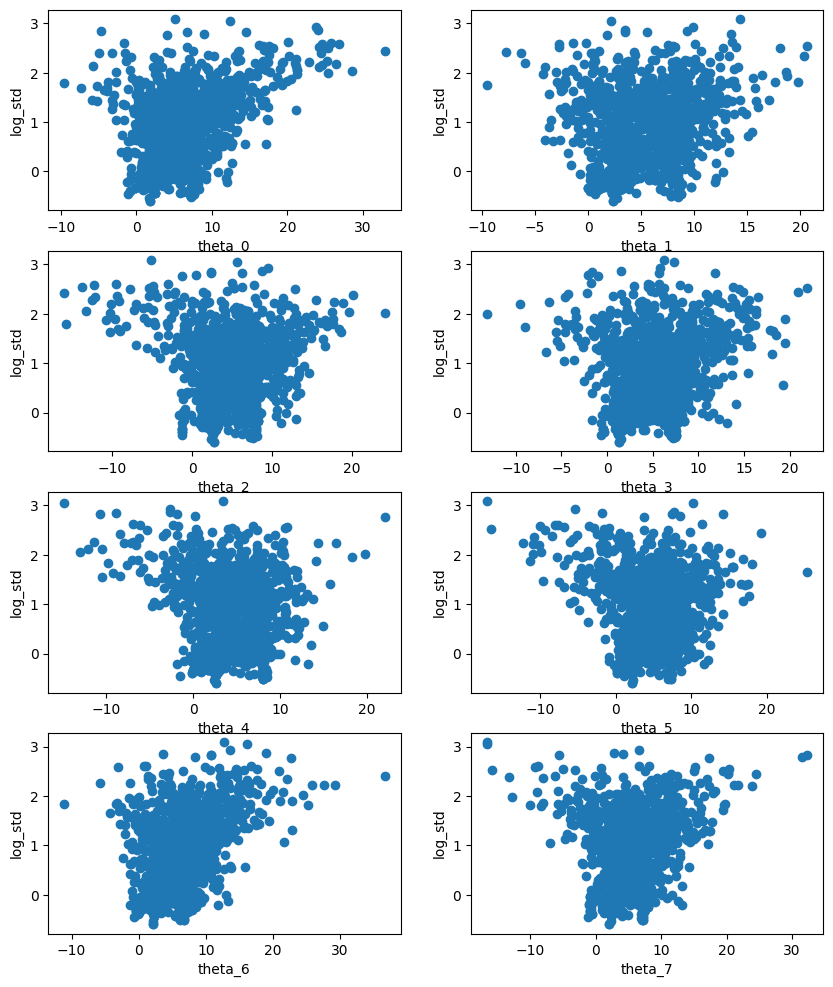

In [12]:
scatterplt(states[0])

In [13]:
acceptance_rate = np.mean(infos[0])
num_divergent = np.mean(infos[1])

print(f"\Average acceptance rate: {acceptance_rate:.2f}")
print(f"There were {100*num_divergent:.2f}% divergent transitions")

\Average acceptance rate: 0.82
There were 3.30% divergent transitions
